In [5]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
  Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
              https://github.com/JayParks/transformer
'''
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
  Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
              https://github.com/JayParks/transformer
'''
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# Transformer Parameters
# Padding Should be Zero index
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5
tgt_len = 5

d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]#获取词->index
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model) #获取角度的x值以便于待会三角函数计算
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]#获取一个角度x值的list

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])#x的list
    #print('sinusoid_table:',sinusoid_table.shape)
    #print('sinusoid_table[:, 0::2]:',sinusoid_table[:, 0::2].shape)
    #print('sinusoid_table[:, 1::2]:',sinusoid_table[:, 1::2].shape)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i     '::'在numpy里表示 start: end: step 所以这里是从第0个开始,间隔为2的取
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)
a=get_sinusoid_encoding_table(src_len+1, d_model)

sinusoid_table: (6, 512)
sinusoid_table[:, 0::2]: (6, 256)
sinusoid_table[:, 1::2]: (6, 256)


sinusoid_table: (6, 512)
sinusoid_table[:, 0::2]: (6, 256)
sinusoid_table[:, 1::2]: (6, 256)
sinusoid_table: (6, 512)
sinusoid_table[:, 0::2]: (6, 256)
sinusoid_table[:, 1::2]: (6, 256)
Epoch: 0001 cost = 2.222323
Epoch: 0002 cost = 0.377521
Epoch: 0003 cost = 0.146424
Epoch: 0004 cost = 0.020179
Epoch: 0005 cost = 0.050622
Epoch: 0006 cost = 0.012932
Epoch: 0007 cost = 0.025760
Epoch: 0008 cost = 0.015582
Epoch: 0009 cost = 0.004516
Epoch: 0010 cost = 0.001901
Epoch: 0011 cost = 0.005775
Epoch: 0012 cost = 0.000423
Epoch: 0013 cost = 0.000477
Epoch: 0014 cost = 0.000366
Epoch: 0015 cost = 0.000431
Epoch: 0016 cost = 0.000288
Epoch: 0017 cost = 0.000213
Epoch: 0018 cost = 0.000423
Epoch: 0019 cost = 0.000230
Epoch: 0020 cost = 0.000535
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


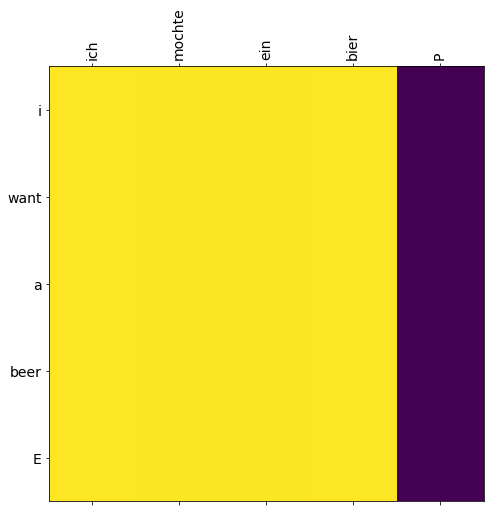

first head of last state dec_self_attns


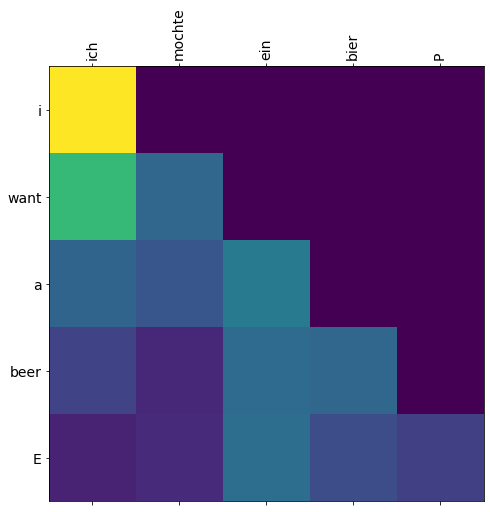

first head of last state dec_enc_attns


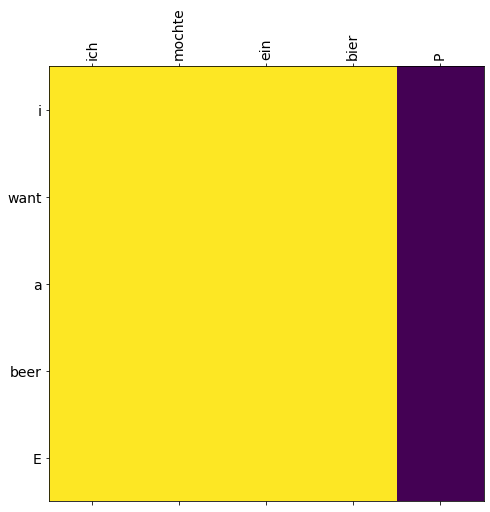

In [6]:
#seq_q是enc_input ,即一个index的Variable,原本是list
def get_attn_pad_mask(seq_q, seq_k):
    # print(seq_q)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking eq()为比较元素相等性，第二个参数可为一个数，或与第一个参数同类型形状的张量 这里是对象的调用就是和0比
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k 创建了一个len_q个相同句子的矩阵

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1) #获取矩阵v的上三角形，k表示对角线起始位置 这样就达到的mask的目的,因为从第一行才开始取
    subsequent_mask = torch.from_numpy(subsequent_mask).byte() #转换数据类型
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)] 得到k矩阵
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores) #归一化
        context = torch.matmul(attn, V) #乘V矩阵得到最终的混合矩阵
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        #把原本的维度拆为8个多头的(其实可以更大不过这里比较方便处理)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k] 
        #torch.repeat() 沿着特定的维度重复这个张量，和expand()不同的是，这个函数拷贝张量的数据。
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask) #得到处理后的注意力矩阵
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2))) #一维卷积
        output = self.conv2(output).transpose(1, 2)
        return nn.LayerNorm(d_model)(output + residual) 
        #残差连接

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention() #注意力层
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 5).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, 5):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

# Test
greedy_dec_input = greedy_decoder(model, enc_inputs, start_symbol=tgt_vocab["S"])
predict, _, _, _ = model(enc_inputs, greedy_dec_input)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)